# Time lag checks L0 fluxes IRGA72 (2016-2024)

# Imports

In [52]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from datetime import datetime
import pandas as pd
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.io.files import load_parquet
from diive.pkgs.analyses.histogram import Histogram
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from diive.core.plotting.plotfuncs import default_format

# Load data

In [53]:
SOURCEFILE = r"02_OPENLAG_EDDYPRO_FLUXNET_OUTPUT_IRGA72_2016-2024.parquet"
df = load_parquet(filepath=SOURCEFILE)
df

Loaded .parquet file 02_OPENLAG_EDDYPRO_FLUXNET_OUTPUT_IRGA72_2016-2024.parquet (0.343 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


,AIR_CP,AIR_DENSITY,AIR_MV,AIR_RHO_CP,AOA_METHOD,AXES_ROTATION_METHOD,BADM_HEIGHTC,BADM_INSTPAIR_EASTWARD_SEP_GA_CH4,BADM_INSTPAIR_EASTWARD_SEP_GA_CO2,BADM_INSTPAIR_EASTWARD_SEP_GA_H2O,BADM_INSTPAIR_EASTWARD_SEP_GA_NONE,BADM_INSTPAIR_HEIGHT_SEP_GA_CH4,BADM_INSTPAIR_HEIGHT_SEP_GA_CO2,BADM_INSTPAIR_HEIGHT_SEP_GA_H2O,BADM_INSTPAIR_HEIGHT_SEP_GA_NONE,...,W_T_SONIC_COV_IBROM_N0004,W_T_SONIC_COV_IBROM_N0008,W_T_SONIC_COV_IBROM_N0016,W_T_SONIC_COV_IBROM_N0032,W_T_SONIC_COV_IBROM_N0065,W_T_SONIC_COV_IBROM_N0133,W_T_SONIC_COV_IBROM_N0277,W_T_SONIC_COV_IBROM_N0614,W_T_SONIC_COV_IBROM_N1626,W_UNROT,W_U_COV,W_VM97_TEST,W_ZCD,ZL,ZL_UNCORR
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 15:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-11 15:45:00,1005.36,1.13966,0.025415,1145.77,0.0,1.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.730810,-1.432500,801010000.0,0.0,0.009173,0.009198
2016-01-11 16:15:00,1005.38,1.13546,0.025509,1141.57,0.0,1.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.052890,-1.801750,801010000.0,0.0,0.008916,0.008932
2016-01-11 16:45:00,1005.40,1.13222,0.025582,1138.33,0.0,1.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.925269,-1.538810,800010000.0,1.0,-0.024976,-0.025218
2016-01-11 17:15:00,1005.41,1.13030,0.025625,1136.42,0.0,1.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.183020,-1.688030,800010000.0,0.0,-0.000850,-0.000857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 22:45:00,1007.82,1.14946,0.025191,1158.44,0.0,1.0,37.0,NaN,1.0,1.0,NaN,NaN,-1.0,-1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065927,-0.196501,800000000.0,9.0,-0.097906,-0.098464
2024-12-31 23:15:00,1007.71,1.14668,0.025253,1155.52,0.0,1.0,37.0,NaN,1.0,1.0,NaN,NaN,-1.0,-1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.115006,-0.316383,800000000.0,3.0,-0.049540,-0.051087
2024-12-31 23:45:00,1007.78,1.15011,0.025177,1159.05,0.0,1.0,37.0,NaN,1.0,1.0,NaN,NaN,-1.0,-1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.087622,0.098774,800000000.0,10.0,0.047854,0.048012


In [54]:
tlag_actual_cols = [c for c in df.columns if c.endswith("_TLAG_ACTUAL")]
tlag_actual_cols

['CH4_TLAG_ACTUAL', 'CO2_TLAG_ACTUAL', 'H2O_TLAG_ACTUAL', 'NONE_TLAG_ACTUAL']

In [55]:
# Time range
# locs = (df.index.year == 2019) & (df.index.month >= 5)
locs = df.index.year == 2021
# locs = (df.index.year == 2017) | (df.index.year == 2018)
# locs = (df.index.year == 2017) & (df.index < "2017-03-15 23:59:00")
# locs = (df.index.year == 2019) & ((df.index > "2019-02-17 23:59:00") & (df.index <= "2019-04-30 23:59:00"))
# locs = (
#         ((df.index > "2019-01-01 23:59:00") & (df.index < "2019-02-18 07:00:00")) |
#         ((df.index > "2019-05-01 07:00:00") & (df.index < "2019-05-22 07:00:00"))
# )
# locs = (df.index > "2020-02-28 23:59:00") & (df.index < "2020-05-13 07:00:00")
# locs = (df.index > "2021-07-23 23:59:00")

tlag_actual = df[tlag_actual_cols][locs].copy()
first_date = tlag_actual.index[0].date()
last_date = tlag_actual.index[-1].date()

In [80]:
def timelags(gascol: str, series: pd.Series, vline1: float, vline2: float, startbin: float, endbin: float):
    # Calculate histogram
    hist = Histogram(
        s=series,
        method='uniques',
        # n_bins=10,
        # ignore_fringe_bins=None
        ignore_fringe_bins=[5, 10]
    )
    results = hist.results
    peakbins = hist.peakbins
    peak = peakbins[0]

    # Restrict shown results
    locs = (results['BIN_START_INCL'] >= startbin) & (results['BIN_START_INCL'] <= endbin)
    results = results[locs].copy()
    hist_bins = results['BIN_START_INCL'].copy()
    hist_counts = results['COUNTS'].copy()

    # Plot
    fig = plt.figure(layout="constrained", facecolor='white', figsize=(21, 16), dpi=72)
    gs = gridspec.GridSpec(1, 1)  # rows, cols
    gs.update(wspace=0.3, hspace=0.3, left=0.03, right=0.97, top=0.97, bottom=0.03)    
    gs = gridspec.GridSpec(2, 1, figure=fig)  # rows, cols
    ax = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    bar_width = .05
    # bar_width = (hist_bins[1] - hist_bins[0]) * 1  # Calculate bar width
    args = dict(width=bar_width, align='edge')
    
    # Axis 1: histogram plot
    ax.bar(x=hist_bins, height=hist_counts, label='counts', zorder=90, color='#78909c', **args)
    title = f"{gascol} (between {first_date} and {last_date})"
    ax.set_title(title, fontsize=24, weight='bold') 
    default_format(ax=ax, ax_xlabel_txt="lag (seconds)", ax_ylabel_txt="counts")
    ax.axvline(peak, color="black")
    ax.axvline(vline1, color="blue")
    ax.axvline(vline2, color="red")
    ax.locator_params(axis='both', nbins=20)
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.text(peak, 0.98, f"PEAK {peak}s",
            size=16, color='black', backgroundcolor='none', transform=trans,
            alpha=1, horizontalalignment='center', verticalalignment='top', zorder=999)
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.text(vline1, 0.70, f"start {vline1}s",
            size=16, color='blue', backgroundcolor='none', transform=trans,
            alpha=1, horizontalalignment='right', verticalalignment='top', zorder=999)
    ax.text(vline2, 0.70, f"end {vline2}s",
            size=16, color='red', backgroundcolor='none', transform=trans,
            alpha=1, horizontalalignment='left', verticalalignment='top', zorder=999)

    # Axis 2: time series
    ax2.plot(series.index, series, alpha=0.5, c='#5f87ae', marker='.', ms=5, ls='none')    
    ax2.axhline(peak, color="black")
    ax2.axhline(vline1, color="blue")
    ax2.axhline(vline2, color="red")
    ax2.locator_params(axis='both', nbins=20)
    default_format(ax=ax2, ax_xlabel_txt="date", ax_ylabel_txt="lag (s)")      
    ax2.set_ylim([hist_bins.iloc[0], hist_bins.iloc[-1]])  # Use same scaling as for ax
    
    fig.show()

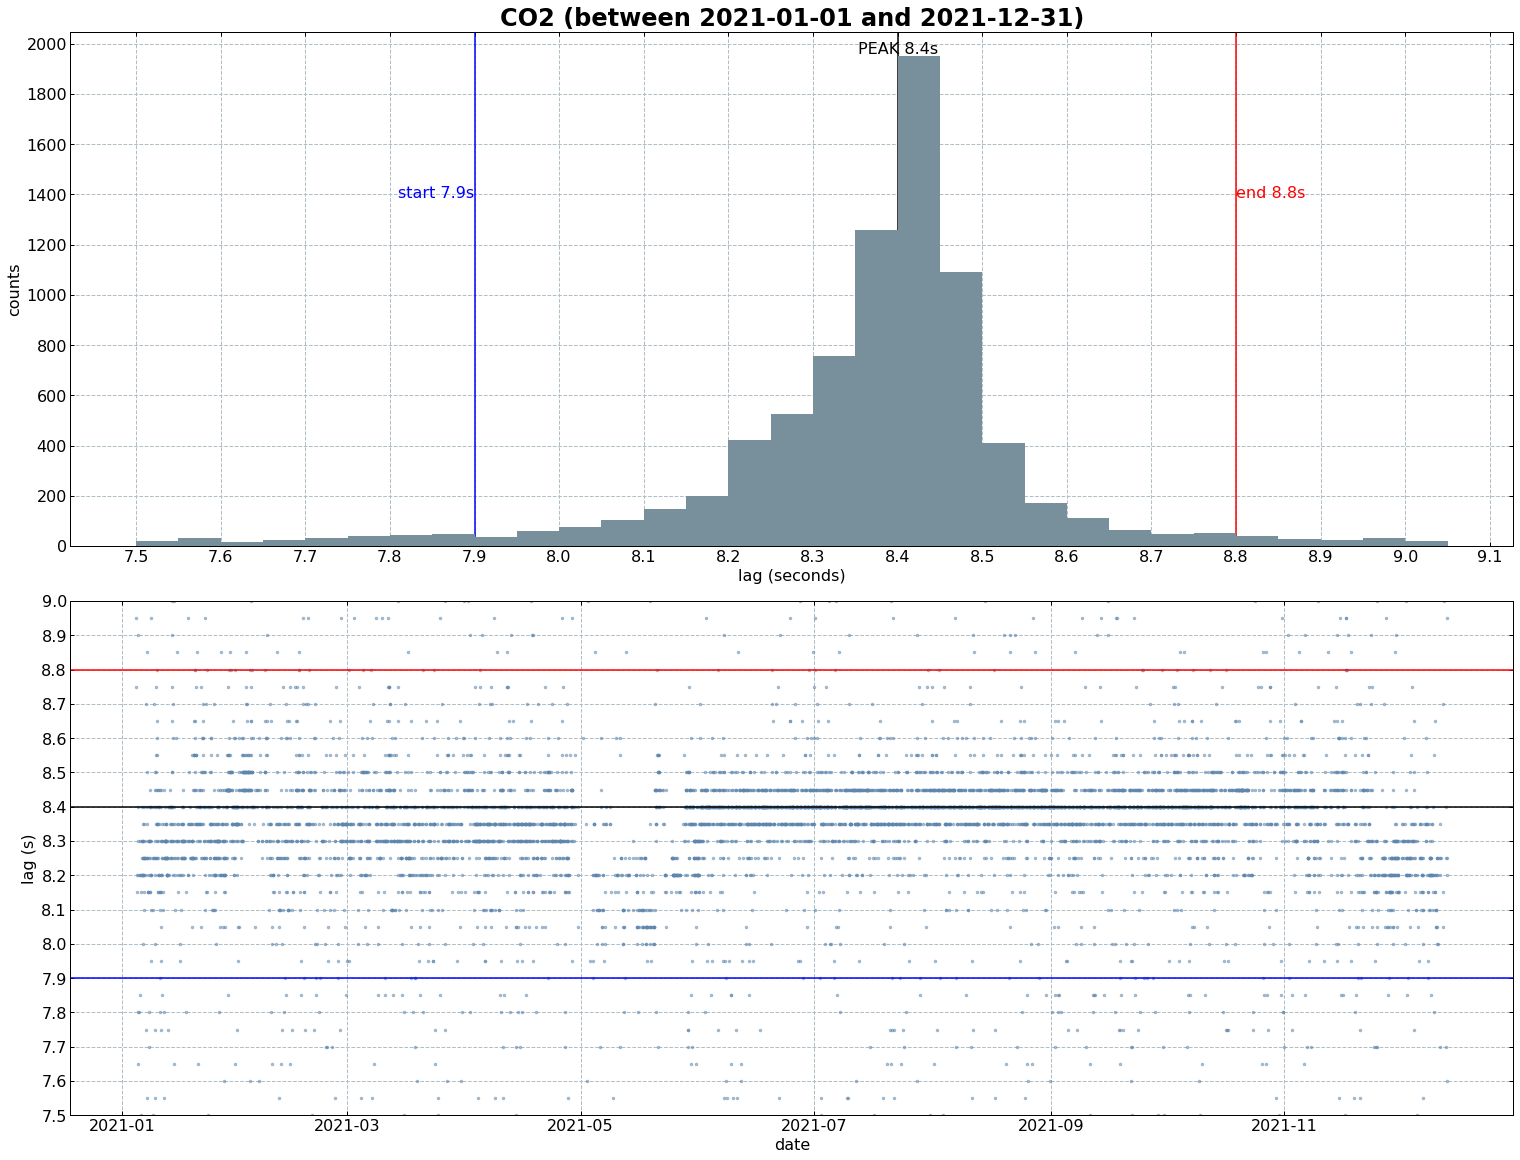

In [87]:
timelags(gascol="CO2", series=tlag_actual["CO2_TLAG_ACTUAL"], vline1=7.9, vline2=8.8, startbin=7.5, endbin=9)

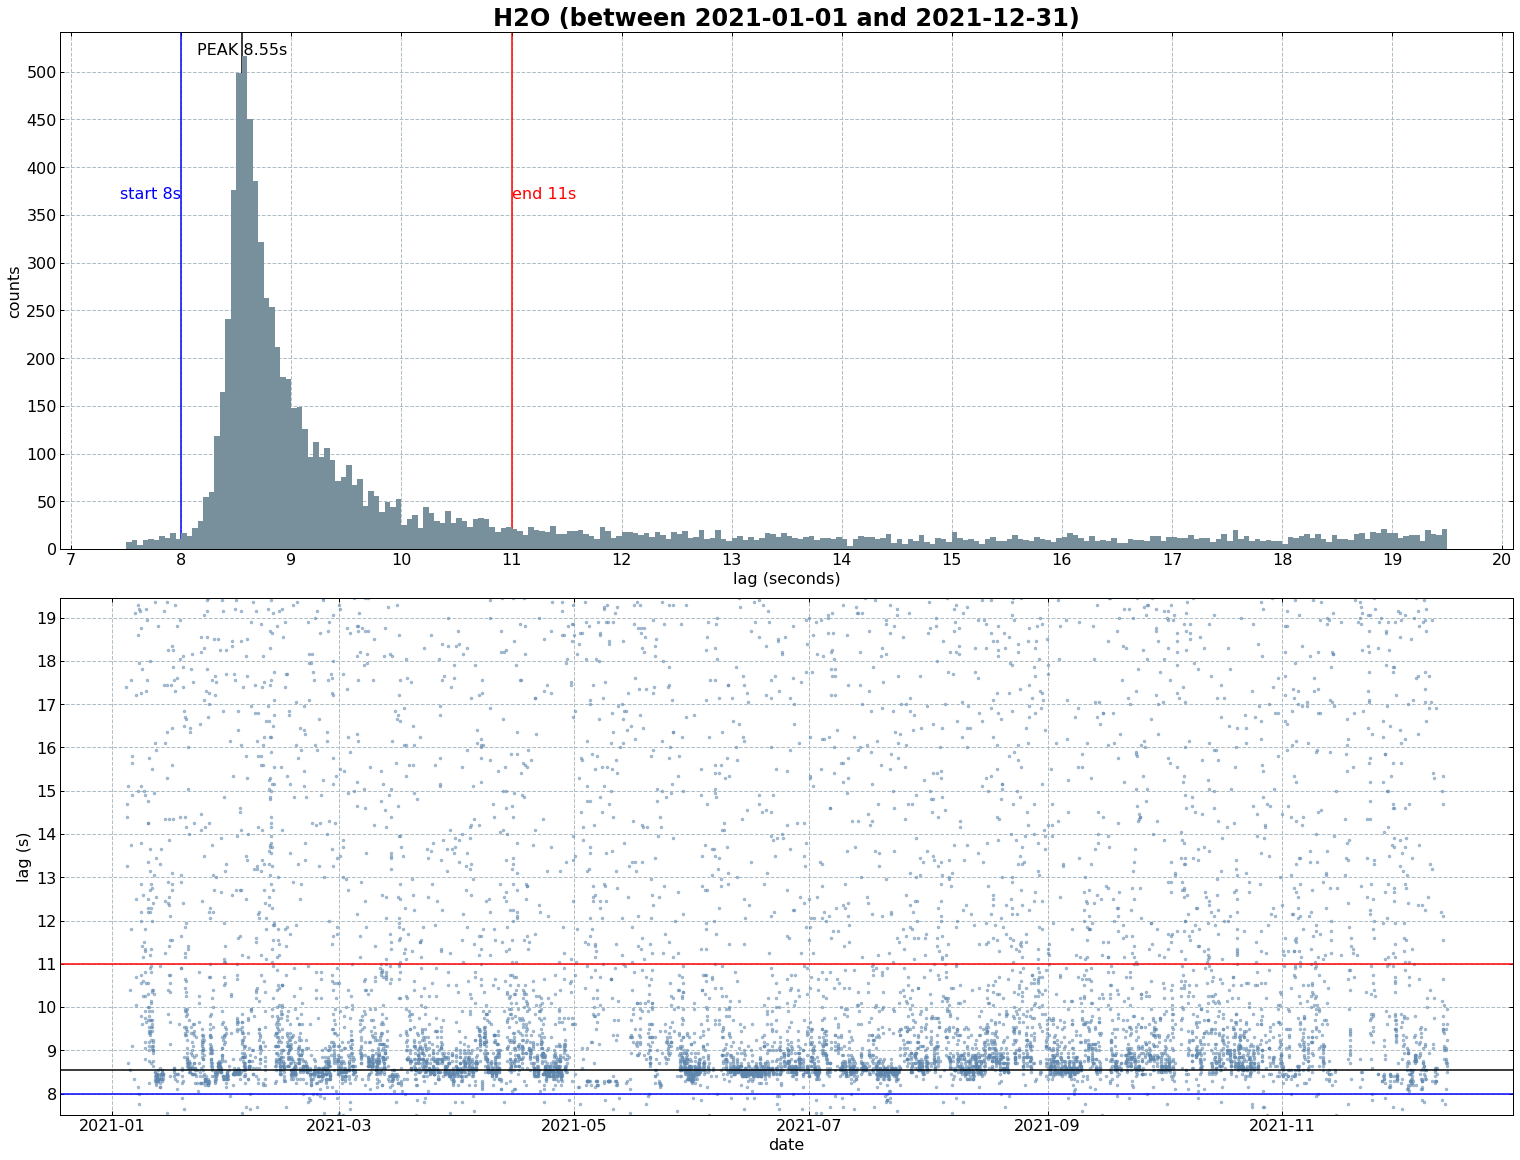

In [86]:
timelags(gascol="H2O", series=tlag_actual["H2O_TLAG_ACTUAL"], vline1=8, vline2=11, startbin=7.5, endbin=20)

# End of notebook.

In [5]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-06-26 16:09:56
